# Проверка гипотез по увеличению выручки в интернет-магазине, оценка результатов А/В-тестирования 



# Описание данных:
# hypothesis
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

# orders
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

# visitors
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и изучение данных

Загрузим нужные библиотеки, которые понадобятся при дальнейшей работе:

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import copy
from scipy import stats as st

Прочитаем файлы:

In [2]:
orders = pd.read_csv('/datasets/orders.csv')
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(orders.head())
orders.info()
orders.isna().sum()


Начальная дата 2019-08-01, конечная дата 2019-08-31



,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Посчитаем количество дубликатов

In [53]:
display(orders.duplicated().sum())

0

In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(visitors.head())
visitors.info()
visitors.isna().sum()


Начальная дата 2019-08-01, конечная дата 2019-08-31



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


date        0
group       0
visitors    0
dtype: int64

Посчитаем количество дубликатов

In [54]:
display(visitors.duplicated().sum())

0

In [6]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
display(hypothesis.head())
pd.set_option('max_colwidth', 500)
hypothesis.info()
hypothesis.isna().sum()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Посчитаем количество дубликатов

In [55]:
display(hypothesis.duplicated().sum())

0

# Вывод:
При первичном изучении данных о гипотезах, заказах и пользователях А/В-теста выяснилось, что пропущенные значения отстутствуют, повторяющихся значений(дубликатов) обнаружено не было. Также для дальнейшей работы с данными понадобилась замена типов для дат в таких столбцах, как date из таблицы orders и date в таблице visitors с помощью метода map(), который позволяет применить lambda-функцию к каждому значению в столбце. Для удобства в работе приведем названия столбцов в таблице hypothesis к нижнему регистру.

### Приведем названия столбцов в hypothesis к нижнему регистру


In [56]:
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts', 'ice',
       'rice'],
      dtype='object')

### Пользователи, попавшие в обе группы А/В-теста

In [58]:
inter = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
display(inter)

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

Пользователей, которые попали в обе группы тестирования, удалим, чтобы не искажать дальнейшие результаты с помощью отрицательной проверки ~ и isin()

In [59]:
display(orders[~orders['visitorId'].isin(inter)].head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


# Вывод:
Были приведены названия столбцов в таблице hypothesis к нижнему регистру. Также была сделала проверка попадания пользователей в обе группы тестирования, найденные пользователи были удалены из данных, чтобы не искажать дальшейние результаты и выводы.

## Часть 1. Приоритизация гипотез.

# ICE = (Impact * Confidence) / Efforts
         

# RICE = (Reach * Impact * Confidence) / Efforts

- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Добавим в существующую таблицу hypothesis столбец 'ice' и отсортируем гипотезы по убыванию 

In [60]:
pd.set_option('max_colwidth', 500)
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by = 'ice', ascending = False).head())

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0


# Вывод:
ICE является одним из самых популярных способов приоритизации задач. Наиболее высокий приоритет имеют гипотезы под номерами: 8 - ее оценка равна 16.2, на втором месте гипотеза под номером 0 - 13.3 и на третьем месте гипотеза под номером 7 с оценкой 11.2. Именно в таком порядке расположились наиболее приоритетные гипотезы, которые стоит проверить в первую очередь.

### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

Аналогично добавим столбец 'rice' и отсортируем гипотезы по убывванию

In [61]:
pd.set_option('max_colwidth', 500)
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis.sort_values(by = 'rice', ascending = False).head())

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


In [65]:
display(hypothesis['hypothesis'].unique())

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

# Вывод:
RICE является модификацией ICE. При приоритизации гипотез методом RICE лидеры изменились. Первое место занимает гипотеза под номером 7 - ее оценка равна 112, на втором месте гипотеза под номером 2 с оценкой 56 и на третьем  месте гипотеза под номерм 0 - ее оценка составляет 40. В таком порядке расположились гипотезы при замене способа ICE на RICE. Изменения произошли за счет того, что оба метода используют разные параметры для расчета оценки,  в случае фреймворка ICE в отличие от RICE мы не учитывали охват изменений, тогда как это важная составляющая оценки гипотез. Но тем не менее, гипотезы под номерами 7 и 0 в обоих случаях находятся в топ-3 гипотез, которые стоит проверять в первую очередь. 

## Часть 2. Анализ A/B-теста

# Проанализируем результаты А/В-теста, которые описаны в датафреймах orders и visitors.

Проверим кол-во пользователей и покупок, совершенными группами A/В- теста, а также проверим гипотезу о разнице кол-ва пользователей в группах

In [14]:
print('Кол-во пользователей в группе А: {}\n'
      'Кол-во пользователей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

Кол-во пользователей в группе А: 18736
Кол-во пользователей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


- Нулевая гипотеза: Разница в количестве посетителей в группах A и B статистически не значима
- Альтернативная гипотеза: Разница в количестве посетителей в группах A и B статистически значима
- Уровень статистической значимости: 5%

In [15]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.7301376549390499
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [16]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [66]:
display(datesGroups.head())

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков:

In [18]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [67]:
display(ordersAggregated.head())

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [20]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [68]:
display(visitorsAggregated.head())

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим обе таблицы в одну и переименуем столбцы:


In [22]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'], how = "inner")
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [69]:
display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


#### Графики кумулятивной выручки по группам A/B-тестирования:

In [24]:
# датафрейм с кумулятивным количеством заказов в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A']

# датафрейм с кумулятивным количеством заказов в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B']


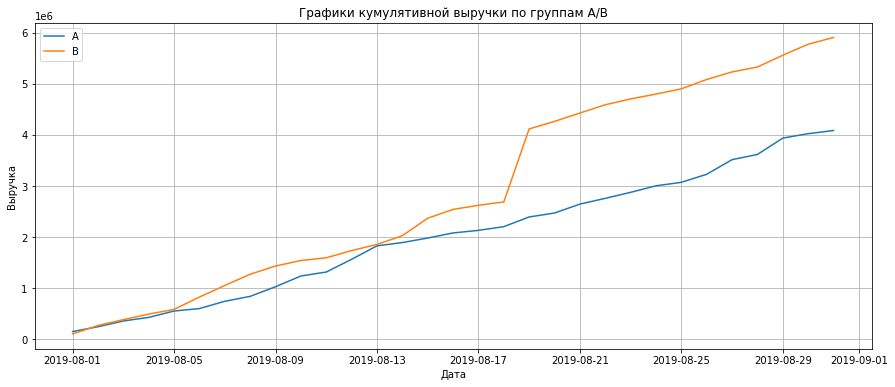

In [25]:
plt.figure(figsize=(15,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.grid()
plt.legend();


# Вывод:
По результатам данного графика стало ясно, что выручка группы В значительно превышает выручку, полученную с группы А. Достаточно хороший результат для группы В. Можно предположить, что внедрение отобранных гипотез сказывается успешно. Но в тоже время резкое повышение значений в группе В с 19.08 указывает на то, что в данных по количеству заказов или выручке присутствуют аномальные значения.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

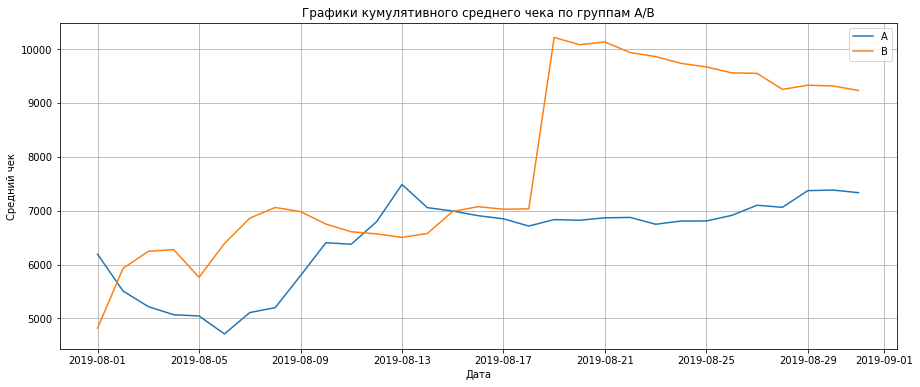

In [26]:
plt.figure(figsize=(15,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего чека по группам А/В')
plt.grid()
plt.legend();

# Вывод:
По полученному графику становится ясно, что средний чек группы В значительно превышеает средний чек пользователей группы A, но стоит обратить внимание на большие скачки среднего чека группы В, это может свидетельствовать об аномалиях и выбросах. Стоит уделить этому внимание на следующих шагах анализа.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

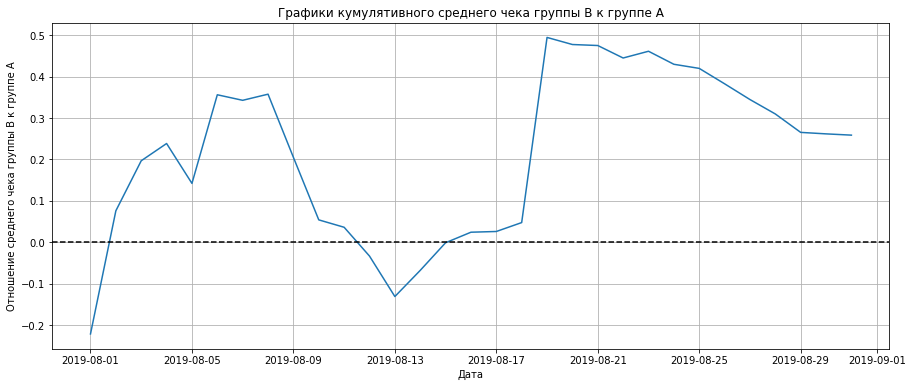

In [28]:
plt.figure(figsize=(15,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.ylabel('Отношение среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего чека группы В к группе А')
plt.grid()
plt.show()


# Вывод:
По графику кумулятивного среднего чека можно сделать предположение, что в данных есть аномалии, выбросы, которые в последующей работе нужно будет найти и выяснить их влияние, в результате от них нужно будет избавиться, ведь они могут искажать данные и давать ложные результаты. Об имеющихся аномалиях свидетельствуют резкие скачки на графике. Подтвердилось предположение, сделанное в предыдущем шаге.

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

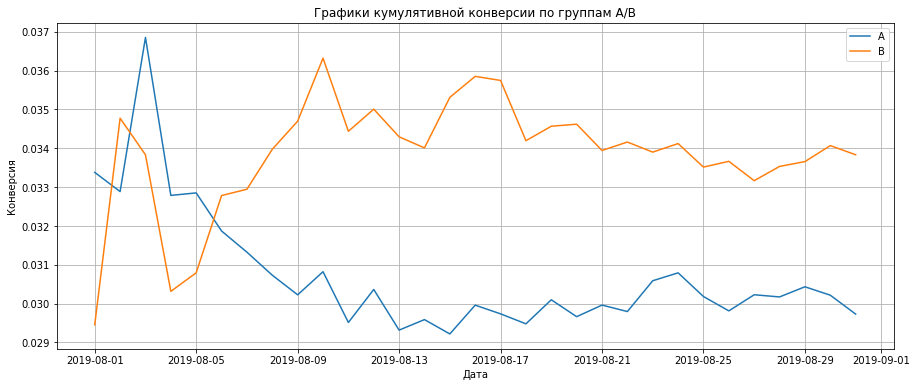

In [30]:
plt.figure(figsize=(15,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('Графики кумулятивной конверсии по группам А/В')
plt.grid()
plt.legend();

# Вывод:
По полученному графику делаем вывод, что конверсия группы В показывает отличные результаты в отличиие от конверсии группы А, она значительно выше и относительно стабильна. Это значит, что пользователи группы В чаще всего совершают какие-то действия на сайте интернет-магазина, а также совершают покупки, тем самым переходя увеличивают прибыль магазина.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

In [31]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

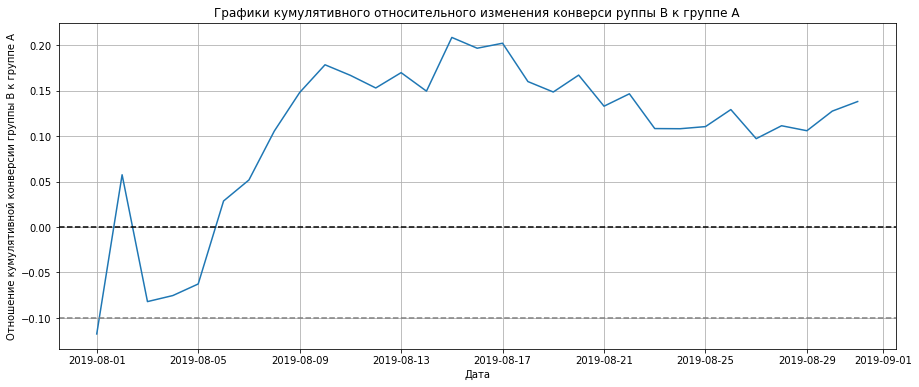

In [32]:
plt.figure(figsize=(15,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.ylabel('Отношение кумулятивной конверсии группы В к группе А')
plt.xlabel('Дата')
plt.title('Графики кумулятивного относительного изменения конверси руппы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.grid()
plt.show()

# Вывод:
По полученному графику можно сделать вывод, что конверсии группы В стабильно больше и лучше конверсии группы А на 10% по истечению 1 недели. Это хороший результат. В промежуточных исследованиях группа В показывает стабильно высокие результаты в отличие от группы А.

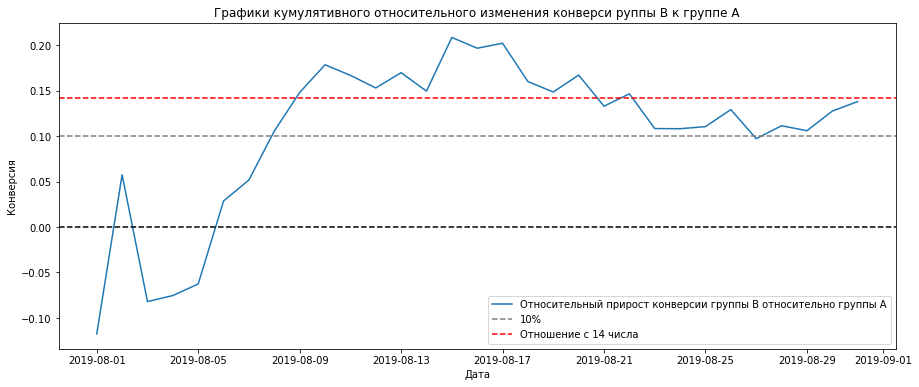

In [33]:
# ячейка ревьюера:
plt.figure(figsize=(15,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('Графики кумулятивного относительного изменения конверси руппы В к группе А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--', label = '10%')
plt.axhline(y=((mergedCumulativeConversions.query('date > "2019-08-13"')['conversionB']/\
                mergedCumulativeConversions.query('date > "2019-08-13"')['conversionA']-1).mean()), 
                color='red', linestyle='--', label = 'Отношение с 14 числа')
plt.legend()
plt.show()

## Изучение аномалий

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [34]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'transactionId']

print(ordersByUsers.sort_values(by='transactionId', ascending=False).head()) 

       visitorId  transactionId
1023  4256040402             11
591   2458001652             11
569   2378935119              9
487   2038680547              8
44     199603092              5


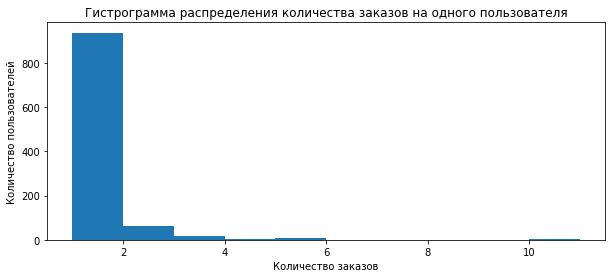

In [35]:
plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['transactionId'])
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()

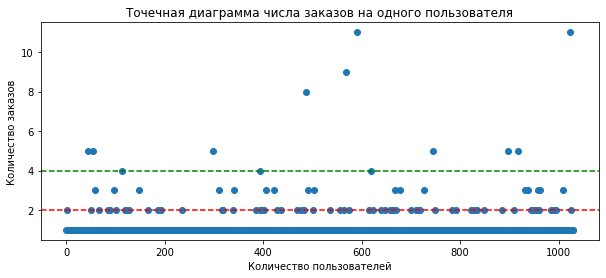

In [36]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['transactionId'])
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.axhline(y=np.percentile(ordersByUsers['transactionId'], 99), color='green', linestyle='--', label = '99 перцентиль')
plt.axhline(y=np.percentile(ordersByUsers['transactionId'], 95), color='red', linestyle='--', label = '95 перцентиль')
plt.show();

# Вывод:
По полученным графикам можно сделать вывод, что большинство пользователей совершают один заказ, но доля пользователей, совершающих 2 заказа тоже значительна, в этом убедились при построении точечной диаграммы, также стало ясно, что существует доля пользователей, совершающих более 2-х покупок, пока неясно считать их аномалиями или нет. Это предстоит проверить.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [70]:
display(np.percentile(ordersByUsers['transactionId'], [90, 95, 99]))

array([1., 2., 4.])

# Вывод:
При подсчете перцентилей стало ясно, что не более 5% пользователей совершали более двух заказов и только 1% пользователей совершали более 4 заказов. Стоит выделить 2 заказа на одного пользователя за нижнюю границу числа заказов и отсеять аномальных пользователей по ней. 

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

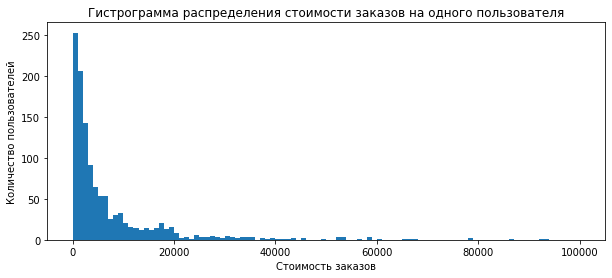

In [38]:
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100) 
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.title('Гистрограмма распределения стоимости заказов на одного пользователя')
plt.show()

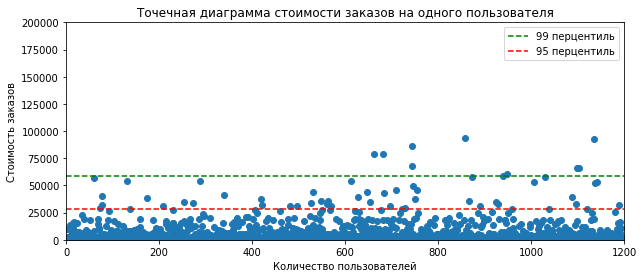

In [39]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 200000])
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.title('Точечная диаграмма стоимости заказов на одного пользователя')
plt.axhline(y=np.percentile(orders['revenue'], 99), color='green', linestyle='--', label = '99 перцентиль')
plt.axhline(y=np.percentile(orders['revenue'], 95), color='red', linestyle='--', label = '95 перцентиль')
plt.legend()
plt.show()

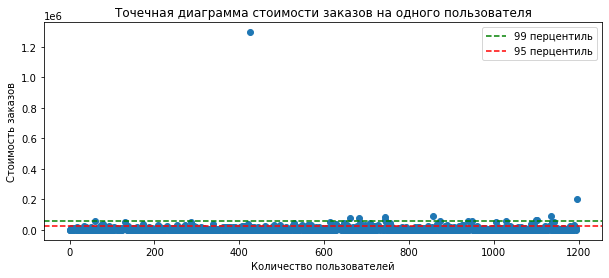

In [40]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
#plt.axis([0, 1200, 0, 200000])
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.title('Точечная диаграмма стоимости заказов на одного пользователя')
plt.axhline(y=np.percentile(orders['revenue'], 99), color='green', linestyle='--', label = '99 перцентиль')
plt.axhline(y=np.percentile(orders['revenue'], 95), color='red', linestyle='--', label = '95 перцентиль')
plt.legend()
plt.show()

# Вывод:
По полученным графикам можно сделать вывод, что большая доля пользователей совершает покупки на сумму не более 25 - 30 тысяч рублей. Но встречаются и аномально большие суммы за одну покупку, что может являться выбросом, ведь такие значения в несколько раз превышают средние значения.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [71]:
display(np.percentile(orders['revenue'], [95, 99]))

array([28000. , 58233.2])

# Вывод:
При подсчете перцентилей стало ясно, что не более 5% пользователей совершали покупки на сумму более 28 тысяч рублей и только 1% пользователей совершали покупки на 58 233. Стоит выделить 28 тысяч рублей за среднюю сумму заказа на одного пользователя за нижнюю границу стоимости заказов и отсеять аномальных пользователей по ней. 

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [42]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

Cоставим списки кол-ва заказов sampleA и sampleB со всеми пользователями (в том числе и не купившими) по группам 

In [43]:
list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

In [44]:
sampleA = pd.concat([ordersByUsersA['orders'],orders_by_non_purchased_users_A],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],orders_by_non_purchased_users_B],axis=0)


print("Статистическая значимость: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост конверсии группы В по отношению к группе А: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Статистическая значимость: 0.017
Относительный прирост конверсии группы В по отношению к группе А: 0.138


- Нулевая гипотеза: Разница в конверсии "сырых" данных групп A и B статистически не значима
- Альтернативная гипотеза: Разница в конверсии "сырых" данных групп A и B статистически значима
- Уровень статистической значимости: 5%

In [45]:
alpha = 0.05
results = st.mannwhitneyu(sampleA, sampleB)
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в конверсии "сырых" данных групп A и B статистически значима')
else:
    print('Разница в конверсии "сырых" данных групп A и B статистически не значима')

p-value: 0.016792355056752608
Разница в конверсии "сырых" данных групп A и B статистически значима


# Вывод:
По полученным данным делаем следующие выводы - статистическая значимость(p-value) равна 0.008 меньше заданного p-value 0.05, из этого следует, что разница статистически значима в конверсии между группами. Относительное превосходство группы В над группой А равно 13.8%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

In [46]:
print('Статистическая значимость: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие в среднем чеке группы В по отношению к группе А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Статистическая значимость: 0.729
Относительное различие в среднем чеке группы В по отношению к группе А: 0.259


- Нулевая гипотеза: Разница в среднем чеке "сырых" данных групп A и B статистически не значима
- Альтернативная гипотеза: Разница в среднем чеке "сырых" данных групп A и B статистически значима
- Уровень статистической значимости: 5%

In [47]:
alpha = 0.05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в среднем чеке "сырых" данных групп A и B статистически значима')
else:
    print('Разница в среднем чеке "сырых" данных групп A и B статистически не значима')

p-value: 0.7292909855432458
Разница в среднем чеке "сырых" данных групп A и B статистически не значима


# Вывод:
По полученным результатам делаем следующие выводы: p-value больше заданной статистической значимости и равен 0.365, это означает, что разницы в среднем чеке групп А и В нет. Но тем не менее средний чек группы В намного превышает средний чек группы А - на 25.9%. Но в то же время различия среднего чека группы В и среднего чека группы А не являются статистически значимыми.

## "Очищенные" данные

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

Ранее было выяснено, что подавляющее большинство пользователей совершает не  более 2 заказов, а сумма 1 покупки в большинстве случаев не превышает 28 000. Очистим данные от аномальных пользователей, которые превышают данные пороговые значения.

Узнаем и посчитаем аномальных пользователей

In [48]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
revenue_lim = np.percentile(orders['revenue'], 95)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Количество аномальных пользователей:', abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
Количество аномальных пользователей: (74,)


Узнаем как их действия повлияли на результаты теста

In [49]:
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('Относительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.173


- Нулевая гипотеза: Разница в конверсии "очищенных" данных групп A и B статистически не значима
- Альтернативная гипотеза: Разница в конверсии "очищенных" данных групп A и B статистически значима
- Уровень статистической значимости: 5%

In [50]:
results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в конверсии "очищенных" данных групп A и B статистически значима')
else:
    print('Разница в конверсии "очищенных" данных групп A и B статистически не значима')

p-value: 0.013042592743036745
Разница в конверсии "очищенных" данных групп A и B статистически значима


# Вывод:
По полученным результатам делаем вывод, что относительный прирост конверсии по "очищенным" данным изменился и стал 17.3%, в то время как по "сырым" данным относительный прирост составлял 13.8% и эта разница статистически значима. Относительный прирост конверсии группы В стал еще больше. p-value почти не изменился. Посмотрим на средний чек. 

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [51]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))
       

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.020


- Нулевая гипотеза: Разница в среднем чеке "очищенных" данных групп A и B статистически не значима
- Альтернативная гипотеза: Разница в среднем чеке "очищенных" данных групп A и B статистически значима
- Уровень статистической значимости: 5%

In [52]:
results = st.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
print('p-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в среднем чеке "очищенных" данных групп A и B статистически значима')
else:
    print('Разница в среднем чеке "очищенных" данных групп A и B статистически не значима')

p-value: 0.738481751314565
Разница в среднем чеке "очищенных" данных групп A и B статистически не значима


# Вывод:
По полученным результатам делаем вывод, что по "очищенным" данным Относительное изменение среднего чека группы В по отношению к группе А уменьшилось,т.е. относительный проигрыш группы В равен 2% соответственно разница между средними чеками стала минимальна. p-value также стабилен и почти не изменился.

## Имеющиеся факты:
- По "сырым" данным в конверсии групп A и B разница статистически значима
- По "сырым" данным разницы в среднем чеке групп A и B нет
- По "очищенным" данным в конверсии групп A и B разница статистически значима
- По "очищенным" данным разницы в средних чеках в группах A и B нет
Стоит также обратить внимание, что кумулятивные метрики по выручке, среднему чеку и конверсии почти все время лидировала группа B. 


## Общий вывод:
При исследовательском анализе интернет-магазина, целью которого было приоритизировать гипотезы, запустить А/В-тестирование и оценить результаты, столкнулись со следующими проблемами с данными:  понадобилась замена типов для дат в таких столбцах, как date из таблицы orders и date в таблице visitors с помощью метода map(), который позволяет применить lambda-функцию к каждому значению в столбце. Для удобства в работе привелии названия столбцов в таблице hypothesis к нижнему регистру. Также были обнаружены пользователи, которые встречались в обеих группах, вследствие чего они были удалены, чтобы не искажать результаты проводимого исследования. Выборка данных имеет корректный размер, проблема подглядывания была исключена.
С помощью способов приоритизации задач ICE и RICE выяснилось, что в первую очередь стоит начать проверять гипотезы под номерами 7, 2 и 0 :
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

 При изучении графиков кумулятивных метрик по выручке, среднему чеку и конверсии почти все время лидирующие позиции занимала группа В. Из-за резких колебаний на графике кумулятивного среднего чека группы В выяснилось, что в данных есть аномалии и выбросы, поэтому были выяснены пороговые значения, по которым в дальнейшем были отфильтрованы данные. Выяснилось, что пользователи совершают не более 2 заказов и средний чек одной покупки равен 28 000.
  После фильтрации данных разница между средними чеками стала минимальна. В то же время До и после очистки данных, показатель конверсии в группе B превосходил показатель конверсии в группе A. В "сырых" данных он был равен 13.8%, в "очищенных" данных он стал даже больше и составил 17.3%. Что свидетельствует об успешных результатах теста. Данная разница в показателях конверсии является статистически значимой, что свидетельствует о том, что А/В-тестирование можно остановить и зафиксировать победу за группой В, ведь на протяжении всего исследования результатов группа В занимала лидирующие позиции и показывала хорошие результаты.